In [1]:
import numpy as np
import pandas as pd

In [4]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

### Test with Data

In [5]:
train_dat = pd.read_csv("./data/train.csv",parse_dates=["activation_date"])
test_dat = pd.read_csv("./data/test.csv",parse_dates=["activation_date"])
print('train data shape: ', train_dat.shape)
print('test data shape: ', test_dat.shape)

train data shape:  (1503424, 18)
test data shape:  (508438, 17)


In [6]:
# Target encode ps_car_11_cat
trn, sub = target_encode(train_dat["category_name"], 
                         test_dat["category_name"], 
                         target=train_dat.deal_probability, 
                         min_samples_leaf=100,
                         smoothing=10,
                         noise_level=0.01)
trn.head(10)

0    0.200305
1    0.190909
2    0.169331
3    0.197310
4    0.279829
5    0.196597
6    0.146772
7    0.046670
8    0.046310
9    0.059942
Name: category_name_mean, dtype: float64

### Scatter plot of category values vs target encoding

Text(0,0.5,'Noisy target encoding')

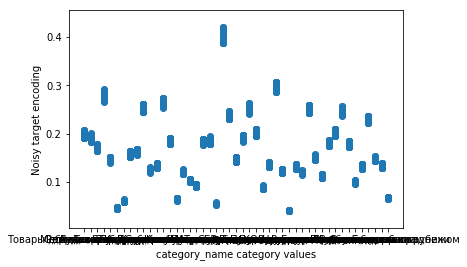

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(train_dat["category_name"], trn)
plt.xlabel("category_name category values")
plt.ylabel("Noisy target encoding")

### Check RMSE Improvement

In [ ]:
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import StratifiedKFold

# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# f_cats = [f for f in trn_df.columns if "_cat" in f]
# print("%20s   %20s | %20s" % ("", "Raw Categories", "Encoded Categories"))
# for f in f_cats:
#     print("%-20s : " % f, end="")
#     e_scores = []
#     f_scores = []
#     for trn_idx, val_idx in folds.split(trn_df.values, trn_df.target.values):
#         trn_f, trn_tgt = trn_df[f].iloc[trn_idx], trn_df.target.iloc[trn_idx]
#         val_f, val_tgt = trn_df[f].iloc[trn_idx], trn_df.target.iloc[trn_idx]
#         trn_tf, val_tf = target_encode(trn_series=trn_f, 
#                                        tst_series=val_f, 
#                                        target=trn_tgt, 
#                                        min_samples_leaf=100, 
#                                        smoothing=20,
#                                        noise_level=0.01)
#         f_scores.append(max(roc_auc_score(val_tgt, val_f), 1 - roc_auc_score(val_tgt, val_f)))
#         e_scores.append(roc_auc_score(val_tgt, val_tf))
#     print(" %.6f + %.6f | %6f + %.6f" 
#           % (np.mean(f_scores), np.std(f_scores), np.mean(e_scores), np.std(e_scores)))